# Fitting Gaussian Profiles

In [96]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import ugradio

### A Quick Aside: Radiometer Equation

The radiometer equation relates the noise/uncertainty on a measurement to the total power (or temperature) entering the system.

\begin{equation}
T_{\rm rms} = \frac{T_{\rm sys}}{\sqrt{2 B t}}
\end{equation}

In [97]:
SIZE = 10000
TSYS = 1
noise = TSYS * np.random.normal(size=SIZE)
#print(np.mean(noise))
#print(np.mean(noise**2))
#print(np.std(noise**2))

In [99]:
def gen_mock_profile(freqs, amp, avg, sig, noise_lev=1):
    signal = ugradio.gauss.gaussval(freqs, amp=amp, avg=avg, sig=sig)
    #signal = 0
    #for T, nu0, sig in zip(Ts, nu0s, sigmas):
    #    signal += T * np.exp(-(nu0 - freqs)**2 / (2 * sig**2))
    return signal + noise_lev * np.random.normal(size=freqs.shape)

<IPython.core.display.Javascript object>


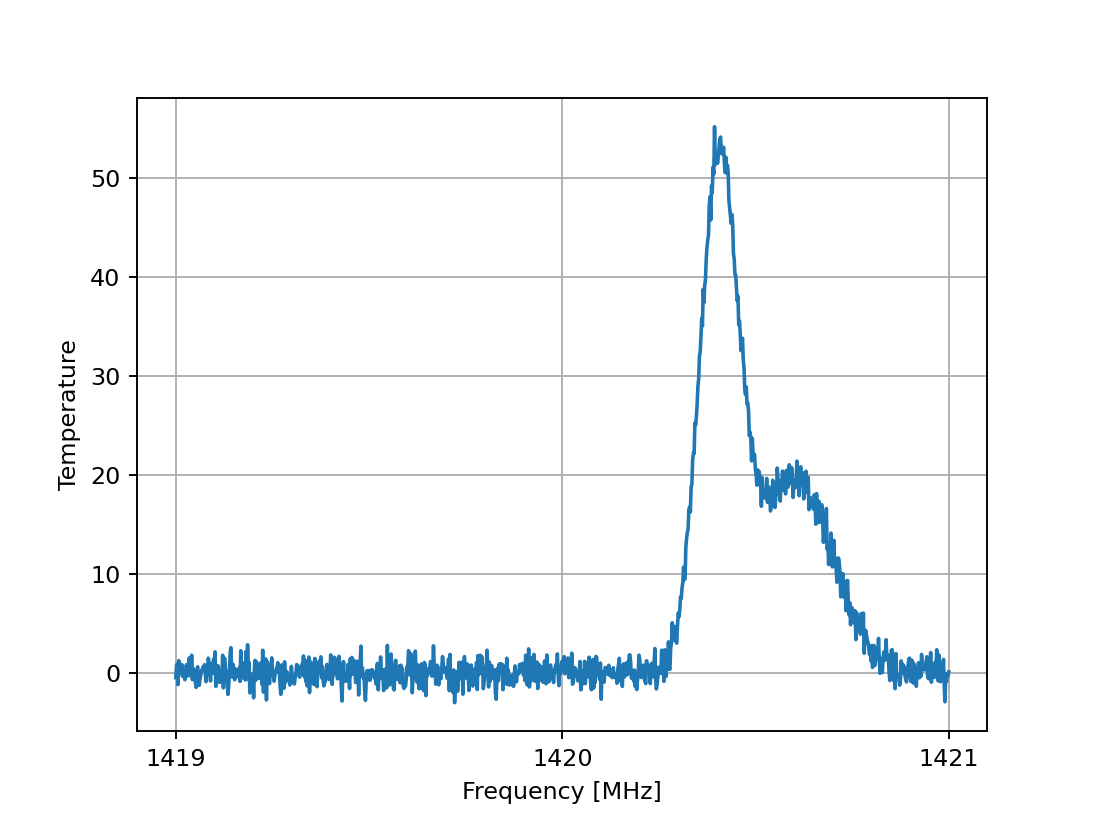

In [103]:
NCHAN = 1024
TSYS = 1
freqs = np.linspace(1419e6, 1421e6, NCHAN)
prms_true = {
    'amp': np.array([50, 20]),
    'avg': np.array([1420.405e6, 1420.6e6]),
    'sig': np.array([0.05e6, 0.1e6])
}
T21 = gen_mock_profile(freqs, noise_lev=TSYS, **prms_true)
plt.figure()
plt.plot(freqs/1e6, T21)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Temperature')
plt.xticks([1419, 1420, 1421])
_ = plt.grid()

In [104]:
ans1 = ugradio.gauss.gaussfit(freqs, T21, amp=20, avg=1420.5e6, sig=1e6)
profile1 = ugradio.gauss.gaussval(freqs, **ans1)

<IPython.core.display.Javascript object>


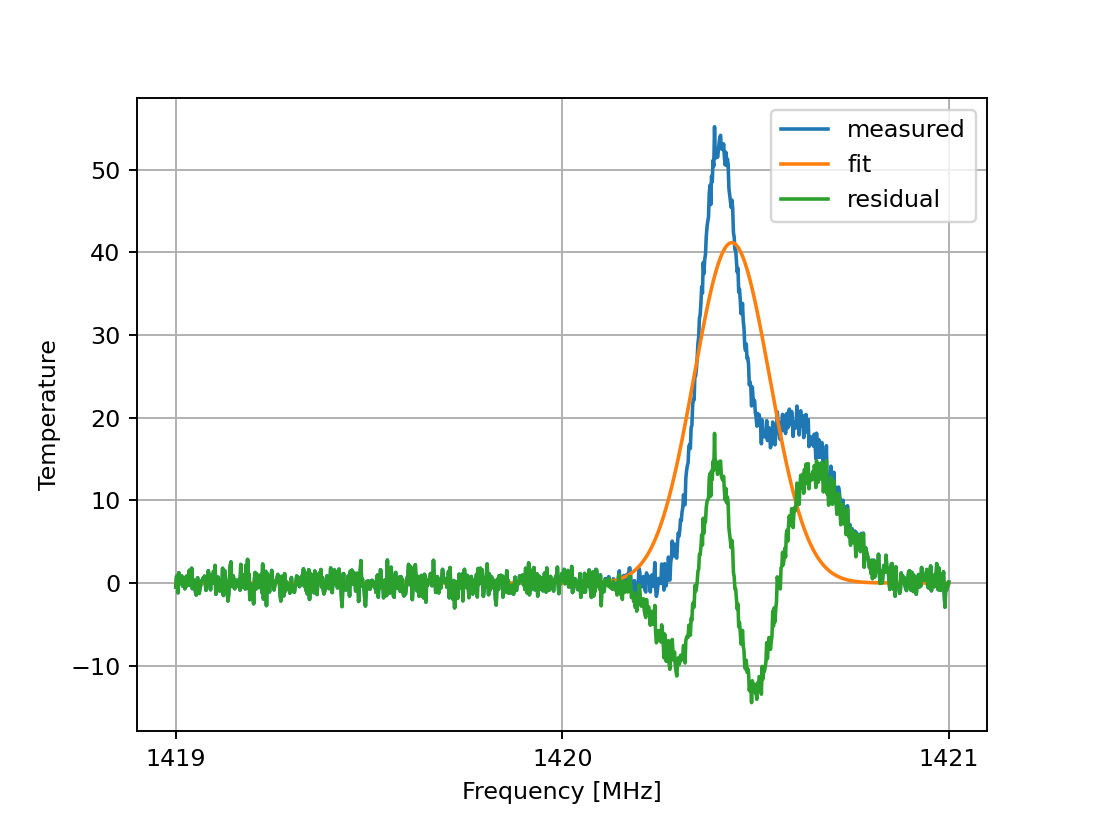

In [105]:
plt.figure()
plt.plot(freqs/1e6, T21, label='measured')
plt.plot(freqs/1e6, profile1, label='fit')
plt.plot(freqs/1e6, T21 - profile1, label='residual')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Temperature')
plt.xticks([1419, 1420, 1421])
plt.legend()
_ = plt.grid()

In [107]:
chisq = np.sum(np.abs(T21 - profile1)**2 / TSYS**2)
print(f'Chi-Square: {chisq}')

Chi-Square: 25241.470622034216


In [108]:
chisq_r = np.sum(np.abs(T21 - profile1)**2 / TSYS**2) / (freqs.size - 3)
print(f'Reduced Chi-Square: {chisq_r}')

Reduced Chi-Square: 24.72230227427445


In [111]:
ans2 = ugradio.gauss.gaussfit(freqs, T21, amp=[20,20], avg=[1420.4e6,1420.6e6], sig=[1e5,1e5])
profile2 = ugradio.gauss.gaussval(freqs, **ans2)

In [112]:
chisq = np.sum(np.abs(T21 - profile2)**2)
print(f'Chi-Square: {chisq}')
chisq_r = np.sum(np.abs(T21 - profile2)**2 / TSYS**2) / (freqs.size - 6)
print(f'Reduced Chi-Square: {chisq_r}')

Chi-Square: 1055.7377453352256
Reduced Chi-Square: 1.0370704767536596


<IPython.core.display.Javascript object>


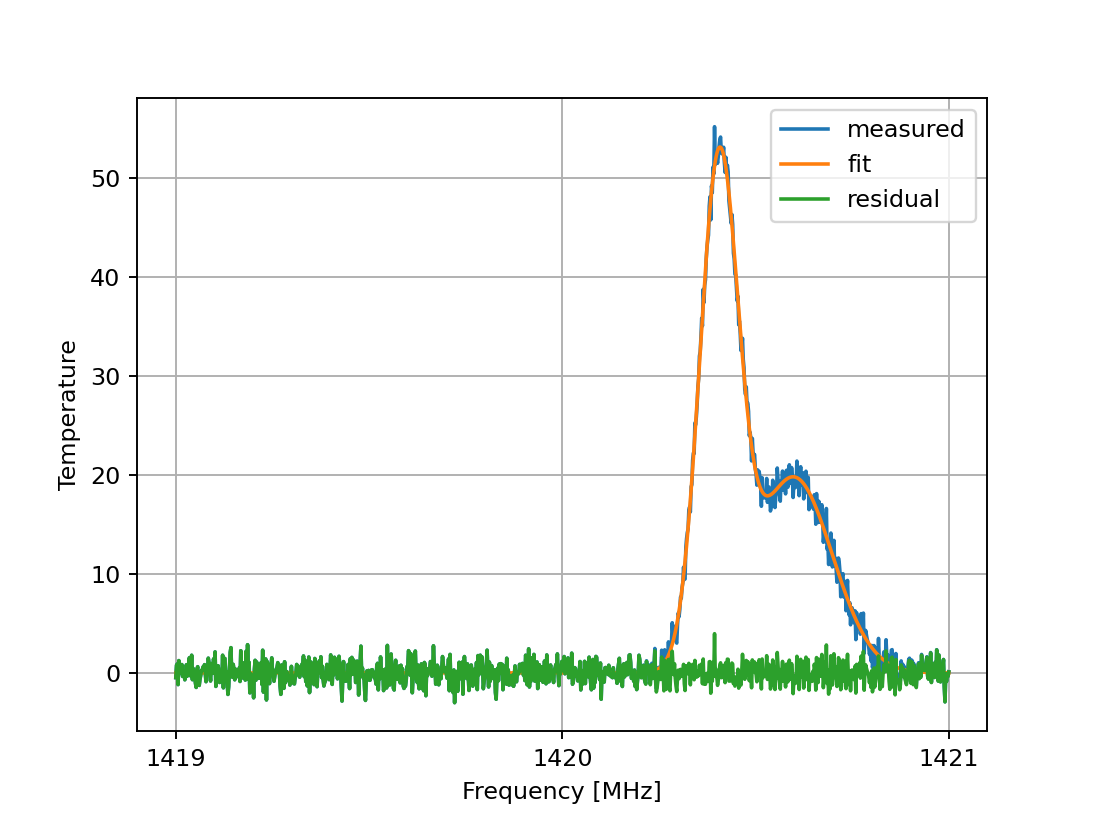

In [113]:
plt.figure()
plt.plot(freqs/1e6, T21, label='measured')
plt.plot(freqs/1e6, profile2, label='fit')
plt.plot(freqs/1e6, T21 - profile2, label='residual')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Temperature')
plt.xticks([1419, 1420, 1421])
plt.legend()
_ = plt.grid()

In [114]:
print(ans2)

{'amp': array([49.97748858, 19.78978572]), 'avg': array([1.42040504e+09, 1.42059822e+09]), 'sig': array([ 50028.16378686, 100093.44946946])}


In [118]:
amp0, amp1 = ans2['amp'].copy()
#amp0, amp1 = prms_true['amp'].copy()
amp0s = np.linspace(0.95*amp0, 1.05*amp0, 200)
chisq = []
for amp0_test in amp0s:
    prms = {k: v.copy() for k, v in ans2.items()}
    #prms = {k: v.copy() for k, v in prms_true.items()}
    prms['amp'] = np.array([amp0_test, amp1])
    _profile = ugradio.gauss.gaussval(freqs, **prms)
    chisq.append(np.sum(np.abs(T21 - _profile)**2/TSYS**2))

49.68867395044682 49.97748858296142 50.26630321547602


<IPython.core.display.Javascript object>


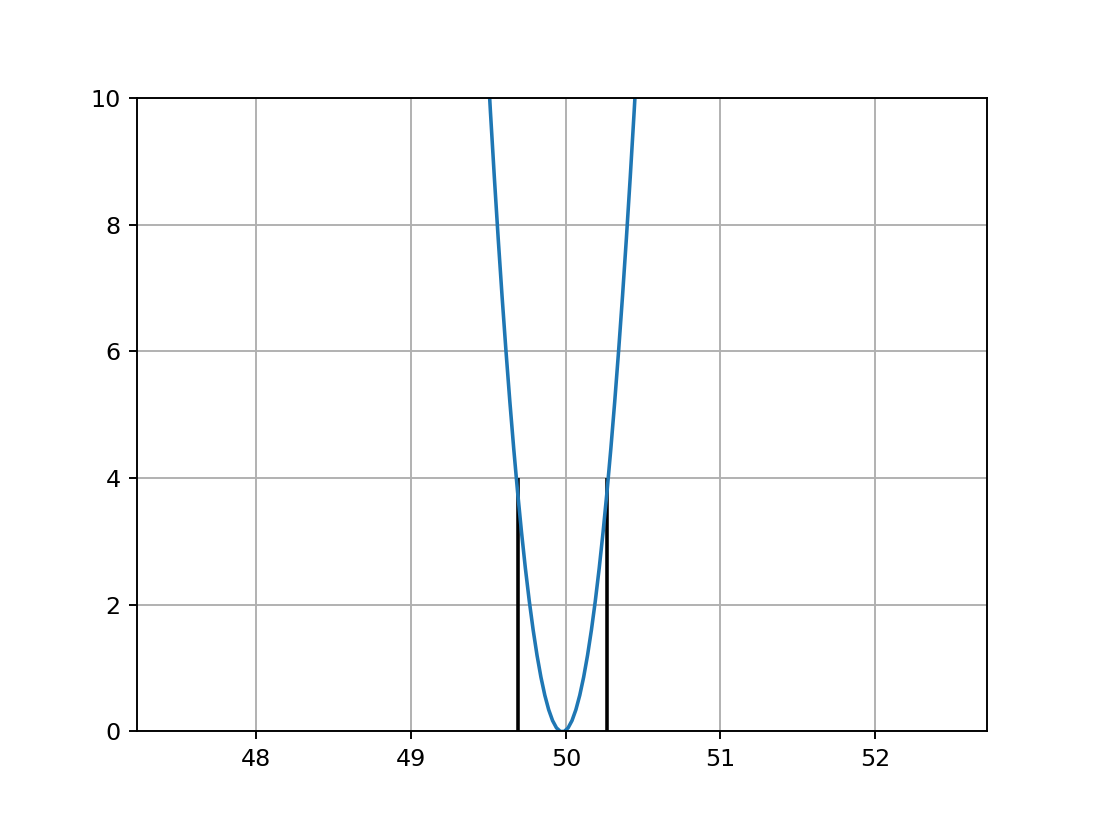

In [121]:
chisq_norm = np.array(chisq).copy()
chisq_norm -= chisq_norm.min()
inds = np.argwhere(chisq_norm < 2**2)
amp_min, amp_max = amp0s[inds[0]], amp0s[inds[-1]]
print(amp_min[0], amp0, amp_max[0])
plt.figure()
plt.plot(amp0s, chisq_norm)
plt.vlines([amp_min, amp_max], ymin=0, ymax=4)
plt.ylim(0, 10)
_ = plt.grid()